# LANGGRAPH CAUSAL MODEL

In [84]:

from __future__ import annotations
import os
import json
from datetime import date, datetime
from pathlib import Path
from typing import List, Optional, Dict, Any, TypedDict, Iterable
from typing_extensions import Annotated
from IPython.display import display, Image, HTML
import copy
import json

import getpass
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor


from dowhy import CausalModel
from econml.dml import LinearDML, CausalForestDML
from econml.cate_interpreter import SingleTreePolicyInterpreter

from joblib import Memory

import markdown
import pdfkit


from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import InMemorySaver

from langchain_core.runnables import Runnable
from langchain_core.prompts import PromptTemplate

from langchain.chains import LLMChain
from langchain.output_parsers import PydanticOutputParser
from langchain_groq import ChatGroq

from typing import Dict, Optional
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import base64
from sklearn.tree import _tree, export_text
from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter
from pydantic import BaseModel


In [85]:


if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your Groq API key:")

In [86]:
llm = ChatGroq(
    model="llama3-70b-8192",  
    temperature=0,
)

In [87]:
CACHE_DIR = "/mnt/data/causal_cache_1"
mem = Memory(CACHE_DIR, verbose=0)

In [88]:
from typing import Optional, Tuple, Dict
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def _preprocess(df: pd.DataFrame, groupby: Optional[str] = None) -> Tuple[pd.DataFrame, Optional[Dict[int, str]]]:
    """
    Cleans the DataFrame by:
    - Dropping fully missing columns
    - Parsing date strings
    - Label encoding object columns
    - Returning label mappings for the groupby column if specified
    
    Returns:
        cleaned_df: pd.DataFrame
        group_mapping: Optional[Dict[int, str]] — e.g. {0: 'Male', 1: 'Female'}
    """
    df = df.copy()
    group_mapping = None

    # Drop fully missing columns
    df = df.dropna(axis=1, how="all")

    # Try parsing string columns as dates
    for col in df.select_dtypes("object"):
        sample = df[col].iloc[0]
        if isinstance(sample, str) and any(c in sample for c in ["-", "/"]):
            try:
                df[col] = pd.to_datetime(df[col])
            except ValueError:
                pass

    # Label encode object columns
    for col in df.select_dtypes("object"):
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        if col == groupby:
            group_mapping = dict(enumerate(le.classes_))

    # Drop remaining NA rows
    df = df.dropna()

    return df, group_mapping


In [89]:
def _summarize_cate(cate: np.ndarray) -> Dict[str, Any]:
    return {
        "cate_mean": float(np.mean(cate)),
        "cate_std": float(np.std(cate)),
        "cate_hist": np.histogram(cate, bins=10)[0].tolist(),
    }

In [90]:
def _pick_estimator(y: pd.Series, t: pd.Series, X: pd.DataFrame) -> Union[LinearDML, CausalForestDML]:
    """Run a cheap heuristic: if linearity holds (High R² in OLS), pick LinearDML, else CF."""
    from sklearn.linear_model import LinearRegression

    ols = LinearRegression().fit(X, y)
    if r2_score(y, ols.predict(X)) > 0.75 and len(X) > 200:
        return LinearDML(model_y=LinearRegression(), model_t=LinearRegression())
    # fallback to CausalForestDML
    return CausalForestDML(
        n_estimators=300,
        min_samples_leaf=10,
        max_depth=None,
        random_state=0,
    )


In [91]:
def get_policy_rules(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined"
        for i in tree_.feature
    ]
    rules = []

    def recurse(node, conditions):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            recurse(tree_.children_left[node], conditions + [f"{name} ≤ {threshold:.2f}"])
            recurse(tree_.children_right[node], conditions + [f"{name} > {threshold:.2f}"])
        else:
            value = tree_.value[node][0]
            class_label = int(np.argmax(value))  # ✅ most likely treatment class
            rule = " and ".join(conditions) if conditions else "Always"
            rules.append(f"If {rule}, then the recommended policy is: Treatment {class_label}.")
    recurse(0, [])
    return rules


In [92]:
import hashlib

def hash_dataframe(df: pd.DataFrame) -> str:
    """Return a short hash of the dataframe contents."""
    df_copy = df.copy()
    df_copy.columns = df_copy.columns.map(str)
    df_bytes = pd.util.hash_pandas_object(df_copy, index=True).values.tobytes()
    return hashlib.md5(df_bytes).hexdigest()


In [93]:


@mem.cache(ignore=["df"])
def _estimate_effects(
    df: pd.DataFrame,
    treatment: str,
    outcome: str,
    controls: list,
    counterfactual_value: Optional[float] = None,
    interpret: bool = False,
    df_hash: Optional[str] = None
) -> Dict[str, any]:

    def get_rules(tree, feature_names):
        tree_ = tree.tree_
        feature_name = [
            feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined"
            for i in tree_.feature
        ]
        rules = []

        def recurse(node, conditions):
            if tree_.feature[node] != _tree.TREE_UNDEFINED:
                name = feature_name[node]
                threshold = tree_.threshold[node]
                recurse(tree_.children_left[node], conditions + [f"{name} ≤ {threshold:.2f}"])
                recurse(tree_.children_right[node], conditions + [f"{name} > {threshold:.2f}"])
            else:
                value = tree_.value[node][0][0]
                rule = " and ".join(conditions) if conditions else "Always"
                rules.append((rule, int(round(value))))
        recurse(0, [])
        return rules

    def explain_policy_rules(tree_text):
        explanation = []
        current_conditions = []

        for line in tree_text.split("\n"):
            depth = line.count("|   ")
            line_clean = line.replace("|   ", "").strip()

            # Truncate to current depth
            current_conditions = current_conditions[:depth]

            if "class:" in line_clean:
                treatment = int(line_clean.split(":")[-1].strip())
                condition_str = " and ".join(current_conditions) if current_conditions else "Always"
                explanation.append(f"If {condition_str}, then the recommended policy is: Treatment {treatment}.")
            elif "<=" in line_clean or ">" in line_clean:
                current_conditions.append(line_clean)

        return explanation

    # --- 1. Fit estimator ---
    X = df[controls]
    T = df[treatment].values.reshape(-1, 1)
    Y = df[outcome]
    est = _pick_estimator(Y, T, X)
    est.fit(Y, T, X=X)

    # --- 2. Basic effects ---
    ate = est.ate(X)
    cate = est.effect(X)
    cate_summary = _summarize_cate(cate)
    mid = len(Y) // 2
    ite_sample = float(est.effect(X.iloc[[mid]]))

    X_cf = X.copy()
    T_cf = np.full_like(T, counterfactual_value if counterfactual_value is not None else T.mean())
    cf_effect = est.effect(X_cf, T0=T, T1=T_cf)

    # --- 3. Root causes ---
    if hasattr(est, "feature_importances_"):
        fi = est.feature_importances_
        root_causes = sorted(zip(controls, fi), key=lambda x: -x[1])[:5]
    else:
        root_causes = []

    feature_differences = []
    for feat, _ in root_causes:
        low_group = X[X[feat] < X[feat].median()]
        high_group = X[X[feat] >= X[feat].median()]
        if len(low_group) == 0 or len(high_group) == 0:
            continue
        eff_low = est.effect(low_group).mean()
        eff_high = est.effect(high_group).mean()
        feature_differences.append({
            "feature": feat,
            "low_effect": float(eff_low),
            "high_effect": float(eff_high),
            "effect_diff": float(eff_high - eff_low)
        })

    root_summary = "\n".join([
        f"When '{f['feature']}' is high, the treatment effect {'increases' if f['effect_diff'] > 0 else 'decreases'} by {abs(f['effect_diff']):.3f} units."
        for f in feature_differences
    ])

    # --- 4. Confidence Interval ---
    if hasattr(est, "cate_interval"):
        lb, ub = est.effect_interval(X)
        ci_summary = {"lower_bound_mean": float(lb.mean()), "upper_bound_mean": float(ub.mean())}
    else:
        ci_summary = {}

    result = {
        "ate": float(ate),
        "cate_summary": cate_summary,
        "ite_sample": ite_sample,
        "counterfactual_example": float(cf_effect.mean()),
        "root_causes": root_causes,
        "uncertainty": ci_summary,
        "root_cause_differences": feature_differences,
        "root_cause_summary_text": root_summary
    }

    if interpret:
        try:
            X.columns = X.columns.map(str)

            # CATE Tree
            cate_interpreter = SingleTreeCateInterpreter(max_depth=3)
            cate_interpreter.interpret(est, X)
            fig, ax = plt.subplots(figsize=(10, 6))
            cate_interpreter.plot(ax=ax, feature_names=controls)
            buf = BytesIO()
            fig.savefig(buf, format="png")
            result["cate_interpreter_tree_png"] = base64.b64encode(buf.getvalue()).decode()
            result["cate_interpreter_rules_llm"] = [
                f"If {cond}, then estimated treatment effect (CATE) is {val:.2f}"
                for cond, val in get_rules(cate_interpreter.tree_model_, list(X.columns))
            ]
            plt.close(fig)

            # Policy Tree
            if np.unique(T).shape[0] == 2:
                policy_interpreter = SingleTreePolicyInterpreter(max_depth=3)
                policy_interpreter.interpret(est, X=X)
                fig, ax = plt.subplots(figsize=(10, 6))
                policy_interpreter.plot(ax=ax, feature_names=controls)
                buf2 = BytesIO()
                fig.savefig(buf2, format="png")
                result["policy_tree"] = base64.b64encode(buf2.getvalue()).decode()
                tree_text = export_text(policy_interpreter.tree_model_, feature_names=list(X.columns))
                result["policy_tree_text"] = tree_text
                result["policy_tree_rules_llm"] = explain_policy_rules(tree_text)
                plt.close(fig)

        except Exception as e:
            result["cate_interpreter_tree_png"] = f"Error generating tree: {str(e)}"
            result["cate_interpreter_rules_llm"] = f"Error: {str(e)}"
            result["policy_tree"] = f"Error generating policy tree: {str(e)}"
            result["policy_tree_rules_llm"] = f"Error: {str(e)}"

    return result


In [48]:
from langgraph.graph import END, StateGraph
from langchain_core.runnables import Runnable
from langchain_groq import ChatGroq
from langchain.prompts import PromptTemplate
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel
from typing import List, Optional, TypedDict

# make sure your model is imported here
import pandas as pd

In [49]:
# def analyze(request: Dict[str, Any]) -> Dict[str, Any]:
#     df: pd.DataFrame = request["df"]
#     treatment: str = request["treatment"]
#     outcome: str = request["outcome"]
#     controls: List[str] = request["controls"]
#     groupby: Optional[str] = request.get("groupby")
#     mode: str = request.get("mode", "ate")
#     counterfactual_value: Optional[float] = request.get("counterfactual_value")
#     interpret: bool = request.get("interpret", False)

#     df, group_mapping = _preprocess(df, groupby=groupby)  # ⬅️ Modified
#     print("Group Mapping:", group_mapping)
#     def apply_estimation(gdf):
#         return _estimate_effects(
#             df=gdf,
#             treatment=treatment,
#             outcome=outcome,
#             controls=controls,
#             counterfactual_value=counterfactual_value,
#             interpret=interpret,
#             df_hash=hash_dataframe(gdf)
#         )

#     if groupby and groupby in df.columns:
#         original_values = df[groupby].copy()
#         if df[groupby].dtype.name == "category" or df[groupby].dtype == "object":
#             le = LabelEncoder()
#             df[groupby] = le.fit_transform(df[groupby])
#             group_mapping = {str(i): str(label) for i, label in enumerate(le.classes_)}
#         else:
#             group_mapping = {str(val): str(val) for val in df[groupby].unique()}
#         print("✅ Group Mapping:", group_mapping)
#         results = {str(gval): apply_estimation(gdf) for gval, gdf in df.groupby(groupby)}
#         return {
#             "groupby": groupby,
#             "mode": mode,
#             "results": results,
#             "group_mapping": group_mapping  # ✅ must return this
#         }

In [50]:
def analyze(request: Dict[str, Any]) -> Dict[str, Any]:
    df: pd.DataFrame = request["df"]
    treatment: str = request["treatment"]
    outcome: str = request["outcome"]
    controls: List[str] = request["controls"]
    groupby: Optional[str] = request.get("groupby")
    mode: str = request.get("mode", "ate")
    counterfactual_value: Optional[float] = request.get("counterfactual_value")
    interpret: bool = request.get("interpret", False)

    # ⬅️ Only encode once here
    df, group_mapping = _preprocess(df, groupby=groupby)
    print("✅ Group Mapping from preprocessing:", group_mapping)

    def apply_estimation(gdf):
        return _estimate_effects(
            df=gdf,
            treatment=treatment,
            outcome=outcome,
            controls=controls,
            counterfactual_value=counterfactual_value,
            interpret=interpret,
            df_hash=hash_dataframe(gdf)
        )

    if groupby and groupby in df.columns:
        results = {str(gval): apply_estimation(gdf) for gval, gdf in df.groupby(groupby)}
        return {
            "groupby": groupby,
            "mode": mode,
            "results": results,
            "group_mapping": group_mapping  # ✅ correct mapping
        }

    return apply_estimation(df)


In [51]:
from typing_extensions import Annotated
from langgraph.graph import StateGraph
#from langgraph.checkpoint import memory_checkpoint
from typing import Optional, List, TypedDict
from pydantic import BaseModel
import pandas as pd

class ParamSchema(BaseModel):
    treatment: str
    outcome: str
    controls: List[str]
    groupby: Optional[str] = None
    mode: str
    counterfactual_value: Optional[float] = None
    interpret: Optional[bool] = False
parser = PydanticOutputParser(pydantic_object=ParamSchema)

In [52]:
class GraphState(TypedDict):
    user_question: Annotated[str, "Input"]
    df: Annotated[pd.DataFrame, "Input"]
    extracted_params: Optional[ParamSchema]
    result: Optional[dict]
    explanation: Optional[str]
    interpretation: Optional[dict]
    tree_visuals: Optional[str]
    tree_text_explanation: Optional[str]
    markdown_report: Optional[str]              
    pdf_path: Optional[str]                     
    should_generate_pdf: Optional[bool]
    json_report: Optional[dict]



In [53]:
from langgraph.checkpoint.memory import InMemorySaver

In [54]:
# import langgraph.graph
# dir(langgraph.graph)

In [55]:
import pandas as pd
import json
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langgraph.graph import StateGraph

# Your `llm` instance (assumed to be defined elsewhere)
# llm = ChatOpenAI(...) or similar

# ------------------ Prompt Chains ------------------

tree_cate_explain_prompt = PromptTemplate(
    input_variables=["cate_interpreter_rules"],
    template="""
You are an expert causal reasoning assistant helping non-technical business stakeholders understand causal decision trees.

You are given a set of decision rules from a model that estimates how a treatment (e.g., discount, price change, feature rollout) affects an outcome (e.g., user engagement, sales). Each rule shows a condition and the estimated treatment effect (called CATE).

Your task is to:
1. Summarize the key groups in plain English.
2. Highlight which features (like price, age, etc.) matter most.
3. Explain how the treatment effect changes for different user/customer types.
4. Keep it simple, visual and jargon-free. Use comparisons if helpful.

Here are the model rules:

{{ cate_interpreter_rules }}

Now write a friendly, easy-to-understand explanation of these rules for a stakeholder who doesn't know what CATE means. Explain what types of customers benefit more or less from the treatment, and what patterns are important.
""".strip()
)
tree_cate_explain = LLMChain(llm=llm, prompt=tree_cate_explain_prompt)

tree_policy_explain_prompt = PromptTemplate(
    input_variables=["policy_tree_rules"],
    template="""
You are a helpful AI assistant explaining a decision policy to business leaders in simple, intuitive terms.

You are given a list of policy rules from a causal model. These rules show which types of users or customers should receive a treatment (like a discount, campaign, or product offer) based on their characteristics (e.g., price, visits, income, etc.).

Your job is to:
1. Summarize how the model makes decisions — who gets the treatment and who doesn’t.
2. Highlight the most important factors (like price, age, usage, etc.) driving these decisions.
3. Explain the logic of the rules using plain language and real-world terms.
4. Help business stakeholders understand how this policy can improve targeting or ROI.
5. Avoid technical terms like "model", "split", or "classifier". Speak like a business analyst.

Here are the recommended policy rules:

{{ policy_tree_rules }}

Now write a clear, business-friendly summary of this policy:
- What types of users should get the treatment?
- What kinds of customers are better left untreated?
- What factors are most important for making this decision?
- What patterns or insights should the business focus on?
""".strip()
)
tree_Policy_explain = LLMChain(llm=llm, prompt=tree_policy_explain_prompt)

# Assume param_chain, explain_chain, and analyze(...) are already implemented


In [56]:

from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain


param_prompt = PromptTemplate(
    input_variables=["columns", "question"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
    template="""
You are a causal-inference assistant. The dataset contains these columns:
{columns}

From the user's question, extract the following:
- treatment: the column being changed or intervened on
- outcome: the column whose causal effect is measured
- controls: list of confounding variables (all columns except treatment and outcome)
    if control is not found or empty, use all columns excpet for treatment and outcome as control 
    always check if all controls that is generated is always be present in coloumns as control will always be a subset of columns
-  groupby: optional column for subgroup analysis (e.g. "how does X differ for men and women" → groupby = gender)
    
- mode: "ate", "cfa", or "rca"
- counterfactual_value: only if user asks for a specific value for the treatment
- interpret: set to true if the user asks for a visual explanation, rule tree, or interpretable model

{format_instructions}

USER QUESTION:
{question}
""".strip()
)


param_chain = param_prompt| llm | parser


In [57]:
explain_prompt = PromptTemplate(
    input_variables=["params", "results", "question","group_mapping","groupby_column"],
    template="""
You are a causal inference assistant. Your task is to explain the results of a causal analysis to a business stakeholder who is not technical.

INPUTS:
params = {params}
results = {results}
question = {question}

Write a clear and concise explanation in plain English. Follow this structure:

1. **Headline Summary**  
   Start with a simple sentence summarizing the *main effect* found by the analysis.
1.1 **Query Explanation**
   Explain the user your interpretation of the user query in a clear and simple and short  way so that the user can cross check for it.
2. **Factors Used for Analysis**  
   Mention the control variables used. Example: “We adjusted for differences in age, region, and previous purchase behavior.”

3. **Counterfactual Explanation**  
   🔧 If a `counterfactual_value` is present in the results:
   - Explain what hypothetical scenario was tested.
   - What change it represents. Example: “We asked: What if education was 9 years instead of the actual values?”

4. **Results Explanation**  
   🔧 Report results based on what is present:
   - If an average treatment effect is reported:
     - Example: “On average, increasing income by 1 unit changes age by +2 years.”
   - If a counterfactual effect is reported:
     - Example: “If education were set to 9 years, expected income would change by -130.”
   - Always use the direction (+/-) to indicate increase or decrease.
   - always give corresponiding number when explaining and explain what it means in simple terms
   - cross check the value and dont give the wrong sign to the values 

5. **Group-Level Insights**  
   🔧 If results are broken down by group (i.e., `groupby` is present):
   - Report differences between groups in a simple way.
   - use {group_mapping} for category names if needed
   
   - Example: “For women, the effect was -120, while for men it was -80.”

6. **Individual-Level Variation (CATE)**  
   - Mention that the Conditional Average Treatment Effect (CATE) captures how the effect varies across individuals.
   - Include the standard deviation if available. Example: “There is moderate variation across individuals (CATE std = 15), meaning the effect is not uniform.”
 

7.2. **Root Cause Breakdown**  
   If `root_causes` and `root_cause_differences` are present:
   -IMPORTANT: when giving the answer in list, always leave a line before starting the list
   - For each top feature, report:
   List the top drivers influencing the outcome when the treatment changes.
    - Explain in plain English. Example: “The biggest factors driving the effect were work experience and job type.”
   - always give the number or percentage for the corresponding root cause 
     - always show the percentage of contribution based on root cause in result
     - **% Contribution**: based on normalized feature importance(take the percentage from the root cause in results)
     - **Effect Direction & Size**: e.g., "When income is high, the effect decreases by 111 units"
     - IMPORTANT: when giving the answer in list, always leave a line before starting the list
   Example:
   - “Income contributes 62.6% to the overall effect. When income is high, the effect decreases by 111 units.”
   - “Songs purchased contributes 14.4% and increases the effect by 49 units when high.”


8.If any decision rules (CATE rules) are available under cate_interpreter_rules_llm in results, analyze them carefully, this is the explnation of the CATE Interpretation tree.

Explain them in **plain, concise business language** suitable for executives or stakeholders with no technical background.

Specifically:

8.1. **Overview**: Start with a 1–2 sentence summary explaining that these rules describe how the treatment effect (e.g., impact of a policy or feature) varies depending on different groups or characteristics in the data.

8.2. **Key Insights**:
    - Identify which combinations of features (e.g., "Age > 40 and Income > 60K") lead to **the highest** positive treatment effects.
    - Identify which combinations result in **the lowest** or even **negative** treatment effects.
    - Use phrases like “Customers who are X tend to benefit more from the treatment” or “The effect is minimal or negative for people with Y characteristics.”

8.3. **Plain-English Translation**:
    - Rewrite a few of the most important rules (2–4 max) using non-technical, natural language.
    - Avoid mathematical symbols like `<=` and use phrases like "less than or equal to" or “under the age of...”
    - Mention CATE values as approximate changes, e.g., “about +2.5 improvement” or “a slight decrease.”

8.4. **Implications**:
    - What can a decision-maker *do* with this information? For example:
        - “This suggests we should focus the intervention on younger users with high browsing time.”
        - “These rules can help personalize marketing or adjust eligibility criteria.”
**Guidelines:**
- Avoid jargon like “regression” or “estimator.”
- Do not mention ATE/CATE acronyms unless needed; prefer business-friendly wording like "average effect" or "individual-level variation."
- Be consistent: if the effect is +130, don’t say it’s a decrease.
- End with a takeaway statement like: “In summary, increasing education to 9 years is expected to lower income for this group, mostly due to differences in work experience and region.”
""".strip()
)
from langchain_core.output_parsers import StrOutputParser

parser = StrOutputParser()
explain_chain = explain_prompt | llm | parser


In [58]:
from langchain_core.prompts import PromptTemplate
import pandas as pd
import numpy as np
from langgraph.graph import StateGraph
from typing import Dict



In [59]:
def extract_params(state: GraphState) -> GraphState:
    question = state["user_question"]
    df = state["df"]
    column_list = ", ".join(df.columns)
    #print("question:",question)
    response = param_chain.invoke({
        "question": question,
        "columns": column_list
    })
    
    print("🧠 Extracted Params:", response)
    state["extracted_params"] = response
    return state

In [60]:
def run_causal_model(state: GraphState) -> GraphState:
    df = state["df"]
    p = state["extracted_params"]

    result = analyze({
        "df": df,
        "treatment": p.treatment,
        "outcome": p.outcome,
        "controls": p.controls,
        "groupby": p.groupby,
        "mode": p.mode,
        "counterfactual_value": p.counterfactual_value,
        "interpret": p.interpret
    })

    state["result"] = result
    return state

In [61]:
# def explain_results(state: GraphState) -> GraphState:
#     params = state["extracted_params"]
#     results = state["result"]
#     question = state["user_question"]
#     print("explain result logs question:",question)
#     def strip_images(obj):
#         if isinstance(obj, dict):
#             return {
#                 k: strip_images(v)
#                 for k, v in obj.items()
#                 if not (k.endswith("_png") or k in ["cate_interpreter_tree_png", "policy_tree"])
#             }
#         elif isinstance(obj, list):
#             return [strip_images(i) for i in obj]
#         return obj

#     cleaned_results = strip_images(copy.deepcopy(results))

#     try:
#         explanation = explain_chain.invoke({
#             "params": json.dumps(params.dict(), indent=2),
#             "results": json.dumps(cleaned_results, indent=2),
#             "question": question
#         })
#         print("explanation:",explanation)
#     except Exception as e:
#         explanation = f"[Error generating explanation: {e}]"

#     state["explanation"] = explanation
#     return state

In [62]:
def explain_results(state: GraphState) -> GraphState:
    import copy
    import json

    params = state["extracted_params"]
    results = state["result"]
    question = state["user_question"]
    print("📌 explain result logs → question:", question)

    group_mapping = results.get("group_mapping", {})  # ✅ Optional group names
    groupby_column = results.get("groupby")

    def remap_group_keys(obj):
        if isinstance(obj, dict):
            return {
                group_mapping.get(str(k), str(k)): remap_group_keys(v)
                for k, v in obj.items()
            }
        elif isinstance(obj, list):
            return [remap_group_keys(i) for i in obj]
        return obj

    def strip_images(obj):
        if isinstance(obj, dict):
            return {
                k: strip_images(v)
                for k, v in obj.items()
                if not (
                    isinstance(k, str) and (k.endswith("_png") or k in ["cate_interpreter_tree_png", "policy_tree"])
                )
            }
        elif isinstance(obj, list):
            return [strip_images(i) for i in obj]
        return obj

    # ✅ First strip images
    cleaned_results = strip_images(copy.deepcopy(results))

    # ✅ Then remap group keys (0 → Male, etc.)
    cleaned_results = remap_group_keys(cleaned_results)

    try:
        explanation = explain_chain.invoke({
            "params": json.dumps(params.dict(), indent=2),
            "results": json.dumps(cleaned_results, indent=2),
            "question": question,
            "group_mapping": json.dumps(group_mapping, indent=2),  # 🧠 Give this to LLM
            "groupby_column": groupby_column
        })
        print("📋 Explanation generated ✅")
    except Exception as e:
        explanation = f"[Error generating explanation: {e}]"
        print("⚠️ Explanation failed:", explanation)

    state["explanation"] = explanation
    return state


In [63]:
def run_interpretation(state: GraphState) -> GraphState:
    params = state["extracted_params"]

    if not params.interpret:
        return state

    try:
        interp = analyze({
            "df": state["df"],
            "treatment": params.treatment,
            "outcome": params.outcome,
            "controls": params.controls,
            "groupby": params.groupby,
            "mode": params.mode,
            "counterfactual_value": params.counterfactual_value,
            "interpret": True
        })
        state["interpretation"] = interp
    except Exception as e:
        state["interpretation"] = {"error": str(e)}

    return state


In [64]:
def extract_tree_models(state: GraphState) -> GraphState:
    interp_result = state.get("result", {})
    groupby = state["extracted_params"].groupby
    group_mapping = interp_result.get("group_mapping", {})  
    print("extract tree group mapping:",group_mapping)
    group_sections = []
    tree_cate_explain_report = ""
    tree_policy_explain_report = ""

    if groupby and "results" in interp_result:
        for group_name, group_result in interp_result["results"].items():
            print("group_name:", group_name)
            readable_name = group_mapping.get(int(group_name), group_name)

            print(f"DEBUG: Group {readable_name} keys: {group_result.keys()}")

            cate_section = ""
            policy_section = ""

            if "cate_interpreter_tree_png" in group_result:
                cate_expl = tree_cate_explain.run(cate_interpreter_rules=group_result.get('cate_interpreter_rules_llm', ''))
                cate_section = f"""
#### CATE Tree
![CATE Tree - {readable_name}](data:image/png;base64,{group_result['cate_interpreter_tree_png']})

**CATE Explanation:**  
{cate_expl}
                """.strip()

            if "policy_tree" in group_result:
                policy_expl = tree_Policy_explain.run(policy_tree_rules=group_result.get('policy_tree_rules_llm', ''))
                policy_section = f"""
#### Policy Tree
![Policy Tree - {readable_name}](data:image/png;base64,{group_result['policy_tree']})

**Policy Explanation:**  
{policy_expl}
                """.strip()

            group_md = f"""
### Group: {readable_name}

{cate_section}

{policy_section}

---
""".strip()

            group_sections.append(group_md)

        state["tree_visuals"] = "\n\n".join(group_sections)
        state["tree_text_explanation"] = ""  # already embedded

    else:
        print("DEBUG: Using global result")
        interpretation_blob = ""
        policy_blob = ""

        if "cate_interpreter_tree_png" in interp_result:
            interpretation_blob += "\n\n### Global CATE Tree\n"
            interpretation_blob += f"![CATE Tree](data:image/png;base64,{interp_result['cate_interpreter_tree_png']})\n"
            tree_cate_explain_report = tree_cate_explain.run(cate_interpreter_rules=interp_result['cate_interpreter_rules_llm'])

        if "policy_tree" in interp_result:
            policy_blob += "\n\n### Global Policy Tree\n"
            policy_blob += f"![Policy Tree](data:image/png;base64,{interp_result['policy_tree']})\n"
            tree_policy_explain_report = tree_Policy_explain.run(policy_tree_rules=interp_result['policy_tree_rules_llm'])

        state["tree_visuals"] = interpretation_blob + policy_blob
        state["tree_text_explanation"] = tree_cate_explain_report + tree_policy_explain_report

    return state


In [65]:
# def build_graph():
#     workflow = StateGraph(GraphState)

#     # Add nodes
#     workflow.add_node("extract_params", extract_params)
#     workflow.add_node("run_model", run_causal_model)
#     workflow.add_node("explain_results", explain_results)
#     workflow.add_node("run_interpretation", run_interpretation)
#     workflow.add_node("extract_tree_models", extract_tree_models)
#     workflow.add_node("compile_markdown", compile_markdown_node)  
#     workflow.add_node("generate_pdf", generate_pdf_node)          

#     # Define the path
#     workflow.set_entry_point("extract_params")
#     workflow.add_edge("extract_params", "run_model")
#     workflow.add_edge("run_model", "explain_results")
#     workflow.add_edge("explain_results", "run_interpretation")
#     workflow.add_edge("run_interpretation", "extract_tree_models")
#     workflow.add_edge("extract_tree_models", "compile_markdown")  
#     workflow.add_edge("compile_markdown", "generate_pdf")          

#     workflow.set_finish_point("generate_pdf")

#     return workflow


In [66]:
from langgraph.graph import StateGraph, END

def build_graph():
    workflow = StateGraph(GraphState)

    # Processing nodes
    workflow.add_node("extract_params", extract_params)
    workflow.add_node("run_model", run_causal_model)
    workflow.add_node("explain_results", explain_results)
    workflow.add_node("run_interpretation", run_interpretation)
    workflow.add_node("extract_tree_models", extract_tree_models)
    workflow.add_node("compile_markdown", compile_markdown_node)
    workflow.add_node("generate_pdf", generate_pdf_node)
    workflow.add_node("compile_json", compile_json_report_node)

    
    workflow.add_conditional_edges(
        "compile_markdown",                   # from this node
        should_generate_pdf_router,          # condition function
        {
            "generate_pdf": "generate_pdf",  # if True
            "compile_json": "compile_json",  # if False
        }
    )

    
    workflow.set_entry_point("extract_params")
    workflow.add_edge("extract_params", "run_model")
    workflow.add_edge("run_model", "explain_results")
    workflow.add_edge("explain_results", "run_interpretation")
    workflow.add_edge("run_interpretation", "extract_tree_models")
    
    # compile_markdown comes before conditional split
    workflow.add_edge("extract_tree_models", "compile_markdown")

    # After generate_pdf → compile_json
    workflow.add_edge("generate_pdf", "compile_json")

    # for sending mcp jsut uncomment below
    #workflow.add_edge("compile_json", "send_mcp") 

    #workflow.set_finish_point("send_mcp")
    workflow.set_finish_point("compile_json")

    return workflow


In [67]:
# if __name__ == "__main__":
#     df = pd.read_csv("pricing_sample.csv")

#     inputs = {
#         "user_question": "how does income effect demand of the product group by membership ",
#         "df": df,
#         "should_generate_pdf": True
#     }
    
#     app = build_graph().compile()
#     final_state = app.invoke(inputs)
    
#     print("📁 PDF saved at:", final_state.get("pdf_path"))
#     print("\n--- 🔍 Causal Explanation ---\n")
#     print(final_state.get("explanation", "No explanation generated."))

#     print("\n📦 Final State Snapshot:")
#     for k, v in final_state.items():
#         print(f"{k}: {type(v)}")

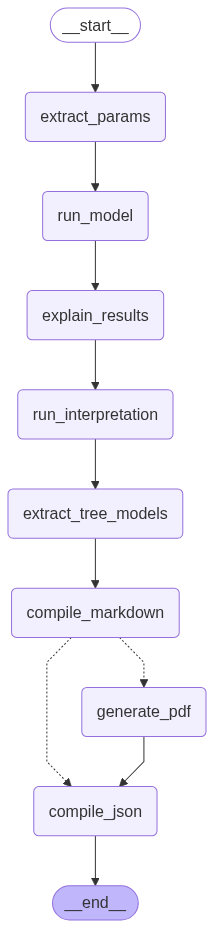

In [82]:

from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))



In [83]:
final_state.get("pdf_path", "PDF not generated")

'causal_report_20250625_110720.pdf'

In [70]:
def should_generate_pdf_router(state: GraphState) -> str:
    return "generate_pdf" if state.get("should_generate_pdf") else "compile_json"



In [71]:
# with open("causal_report.md", "w", encoding="utf-8") as f:
#     f.write("# Causal Explanation Report\n")
#     f.write("## Summary\n")
#     f.write(final_state.get("explanation", "No explanation"))
#     f.write("\n\n## Tree Visuals\n")
#     f.write(final_state.get("tree_visuals", "No tree visuals"))
#     f.write("\n\n## Explanation\n")
#     f.write(final_state.get("tree_text_explanation", "No tree explanation"))
# use this to save in markdown format

In [72]:
def compile_markdown_node(state: GraphState) -> GraphState:
    md_text = compile_markdown_report(state)
    state["markdown_report"] = md_text
    print("compile node done",md_text)
    return state


In [73]:
# def compile_markdown_report(final_state: dict) -> str:
#     md_text = ""
#     md_text += "# Causal Explanation Report\n"
#     md_text += "## Summary\n"
#     md_text += final_state.get("explanation", "No explanation")
#     md_text += "\n\n## Tree Visuals\n"
#     md_text += final_state.get("tree_visuals", "No tree visuals")
#     md_text += "\n\n## Explanation\n"
#     md_text += final_state.get("tree_text_explanation", "No tree explanation")
#     print(md_text)
#     return md_text
def compile_markdown_report(final_state: dict) -> str:
    md_text = ""
    md_text += "# Causal Explanation Report\n"
    md_text += "## Summary\n"
    md_text += final_state.get("explanation", "No explanation")

    md_text += "\n\n## Tree Visuals\n"
    md_text += final_state.get("tree_visuals", "No tree visuals")

    # Only include the explanation if no groupby is used (i.e., tree_text_explanation is global)
    result = final_state.get("result", {})
    has_groupby = isinstance(result, dict) and "results" in result

    if not has_groupby:
        md_text += "\n\n## Explanation\n"
        md_text += final_state.get("tree_text_explanation", "No tree explanation")

    return md_text



In [74]:
import markdown
import pdfkit
from datetime import date
from pathlib import Path

def generate_causal_pdf(
    md_text: str,
    output_pdf: str,
    wkhtmltopdf_path: str,
    logo_url: str = "https://kokar-ai.com/wp-content/uploads/2024/12/site-logo-8.png",
    company_name: str = "Kokar AI"
):
    today = date.today().strftime("%B %d, %Y")

    # Load markdown content
    
    #md_text = response

    # Convert markdown to HTML
    html_body = markdown.markdown(md_text, extensions=["fenced_code", "tables"])

    # cover Page annd content
    html_template = f"""
    <!DOCTYPE html>
    <html>
    <head>
      <meta charset="utf-8">
      <title>{company_name} Causal Report</title>
      <style>
          body {{
              font-family: 'Segoe UI', sans-serif;
              font-size: 12pt;
              line-height: 1.6;
              color: #333;
              padding: 40px;
          }}
          h1, h2, h3 {{
              color: #1A1A1A;
              border-bottom: 1px solid #ccc;
              padding-bottom: 5px;
              margin-top: 40px;
          }}
          img {{
              max-width: 100%;
              height: auto;
              margin: 20px 0;
          }}
          .page-break {{
              page-break-before: always;
          }}
          .cover {{
              text-align: center;
              margin-top: 120px;
          }}
          .cover h1 {{
              font-size: 32pt;
              margin-bottom: 10px;
          }}
          .cover h2 {{
              font-weight: normal;
              color: #555;
              margin-top: 0;
          }}
          .cover p {{
              margin-top: 40px;
              font-size: 14pt;
              color: #888;
          }}
      </style>
    </head>
    <body>
      <!-- COVER PAGE -->
      <div class="cover">
        <img src="{logo_url}" alt="Company Logo" style="height: 80px;">
        <h1>Causal Impact Report</h1>
        <h2>Generated by {company_name}</h2>
        <p>Report Date: {today}</p>
      </div>
      
      <div class="page-break"></div>
      
      {html_body}
    </body>
    </html>
    """

    
    html_file = "temp_report.html"
    with open(html_file, "w", encoding="utf-8") as f:
        f.write(html_template)

    
    header_html = f"""
    <!DOCTYPE html>
    <html>
    <head>
      <style>
        body {{
            font-family: 'Segoe UI', sans-serif;
            font-size: 10pt;
            margin: 0;
            padding: 0 10px;
        }}
        .header {{
            display: flex;
            justify-content: space-between;
            align-items: center;
            border-bottom: 1px solid #ccc;
            padding-bottom: 5px;
        }}
        .header img {{
            height: 30px;
        }}
      </style>
    </head>
    <body>
      <div class="header">
        <img src="{logo_url}" alt="Logo">
        <div><strong>{company_name}</strong> — Causal Report</div>
      </div>
    </body>
    </html>
    """
    header_path = "header.html"
    with open(header_path, "w", encoding="utf-8") as f:
        f.write(header_html)

    # footer
    footer_html = """
    <!DOCTYPE html>
    <html>
    <head>
      <style>
        body {
          font-family: 'Segoe UI', sans-serif;
          font-size: 10pt;
          margin: 0;
          padding: 0;
          text-align: center;
        }
      </style>
    </head>
    <body>
      <div>Page [page] of [topage]</div>
    </body>
    </html>
    """
    footer_path = "footer.html"
    with open(footer_path, "w", encoding="utf-8") as f:
        f.write(footer_html)

    # Configure wkhtmltopdf path
    config = pdfkit.configuration(wkhtmltopdf=wkhtmltopdf_path)

    
    options = {
        'page-size': 'A4',
        'margin-top': '30mm',     
        'margin-bottom': '20mm',   
        'header-html': header_path,
        'header-spacing': '5',
        'footer-html': footer_path,
        'footer-spacing': '5',
        'encoding': "UTF-8"
    }

    
    pdfkit.from_file(html_file, output_pdf, configuration=config, options=options)
    print(f"✅ PDF saved as: {output_pdf}")
    from IPython.display import display, HTML
    display(HTML(html_file))
    
    Path(html_file).unlink()
    Path(header_path).unlink()
    Path(footer_path).unlink()



In [75]:
def generate_pdf_node(state: GraphState) -> GraphState:
    from datetime import datetime

    if not state.get("should_generate_pdf", False):
        print("Skipping PDF generation as per flag.")
        return state

    # Compile Markdown
    md_text = compile_markdown_report(state)
    state["markdown_report"] = md_text  # Store if needed later

    # Generate file name
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    pdf_filename = f"causal_report_{timestamp}.pdf"

    # Generate the PDF
    generate_causal_pdf(
        md_text=md_text,
        output_pdf=pdf_filename,
        wkhtmltopdf_path="C:/Program Files/wkhtmltopdf/bin/wkhtmltopdf.exe",  # <- Adjust path as needed
    )

    state["pdf_path"] = pdf_filename
    print("pdf node done")
    return state


In [76]:
def compile_json_report_node(state: GraphState) -> GraphState:
    report = {
        "causal_explanation": state.get("explanation", "No explanation"),
        "parameters": state.get("extracted_params", {}),
        "question": state.get("user_question", "Unknown question"),
        "tree_visuals": None,
        "tree_explanation": None,
        "groups": []
    }

    interpret = getattr(state.get("extracted_params", {}), "interpret", False)
    result = state.get("result", {})
    group_results = result.get("results") if isinstance(result, dict) else None
    group_mapping = result.get("group_mapping", {})  # ✅ get group label mapping

    if interpret:
        if group_results:
            for group_id, group_data in group_results.items():
                # Use human-readable label if available
                group_name = group_mapping.get(int(group_id), group_id)

                image = group_data.get("cate_interpreter_tree_png")
                image_url = f"data:image/png;base64,{image}" if image else None
                explanation = group_data.get("cate_interpreter_rules_llm", None)

                report["groups"].append({
                    "group": group_name,
                    "tree_image": image_url or "No visual",
                    "tree_rules": explanation or "No explanation"
                })
        else:
            report["tree_visuals"] = state.get("tree_visuals", "No tree visuals")
            report["tree_explanation"] = state.get("tree_text_explanation", "No tree explanation")

    # Add final JSON report to the graph state
    state["json_report"] = report
    return state


In [77]:
import requests  # You can replace this with your own MCP client if needed

def send_json_report_mcp_node(state: GraphState) -> GraphState:
    """
    Sends the compiled JSON report to a downstream system like a chatbot, webhook, or message broker.
    """
    report = state.get("json_report")
    if not report:
        print("🚨 No JSON report found in state.")
        return state

    # Example: Replace this with your actual MCP/Webhook URL
    mcp_endpoint = "https://your-mcp-endpoint.com/report"

    try:
        response = requests.post(mcp_endpoint, json=report)
        if response.status_code == 200:
            print("✅ Report successfully sent to MCP.")
        else:
            print(f"⚠️ MCP returned status {response.status_code}: {response.text}")
    except Exception as e:
        print(f"🚨 Error sending report to MCP: {e}")

    # Optionally store MCP response or status
    state["mcp_sent"] = True
    return state


In [78]:
from typing import List, Optional
from pydantic import BaseModel, Field
import pandas as pd

from langchain_groq import ChatGroq
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

In [101]:

inputs = {
    "user_question": "how does iron ore effect stainless steel price",
    "df": df,
    "should_generate_pdf": True  # ← set True only when PDF is needed
}
app = build_graph().compile()
final_state = app.invoke(inputs)

# Output
#print("📦 JSON Report:", final_state["json_report"])
#print("📄 PDF Path:", final_state.get("pdf_path", "PDF not generated"))


🧠 Extracted Params: treatment='IronOre_Global_USD' outcome='StainlessSteelPrice' controls=['Steel_Inventory_M_USD', 'Steel_Orders_M_USD', 'CoalAustralia_Global_USD', 'Energy_Index', 'Nickel_Global_USD', 'Zinc_Global_USD', 'Freight_Transport_Index', 'WTI_Crude_Global_USD', 'Baltic_Dry_Index', 'BCI_China', 'BCI_Europe', 'BCI_US', 'CLI_China', 'CLI_Europe', 'CLI_US', 'PMI_US_Manufacturing', 'Copper_Global_USD'] groupby=None mode='ate' counterfactual_value=None interpret=False
✅ Group Mapping from preprocessing: None


KeyError: "['Copper_Global_USD'] not in index"

📦 JSON Report: {'causal_explanation': 'Here is the explanation:\n\n**Headline Summary**\nThe city where a customer is located has a negative effect on their loyalty score, on average decreasing it by 0.14 units.\n\n**Query Explanation**\nWe analyzed how the city where a customer is located affects their loyalty score, while controlling for other factors such as customer ID, store ID, product ID, and customer demographics.\n\n**Factors Used for Analysis**\nWe adjusted for differences in customer ID, store ID, product ID, category, quantity, unit price, total price, name, age, gender, category, unit price, and store location.\n\n**Counterfactual Explanation**\nNo counterfactual scenario was tested in this analysis.\n\n**Results Explanation**\nOn average, the city where a customer is located decreases their loyalty score by 0.14 units.\n\n**Group-Level Insights**\nNo group-level insights are available for this analysis.\n\n**Individual-Level Variation (CATE)**\nThere is moderate variation
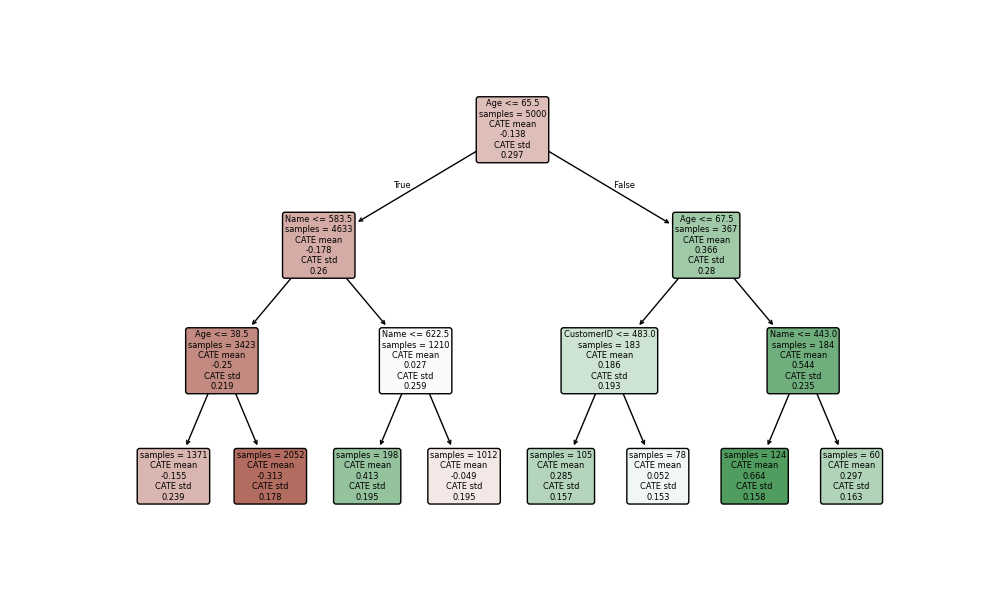

In [80]:
print("📦 JSON Report:", final_state["json_report"])

In [100]:
df = pd.read_csv("Stainless-Steel-Prices-Forecasty-Assignment.csv")

df

,Date,StainlessSteelPrice,Steel_Inventory_M_USD,Steel_Orders_M_USD,IronOre_Global_USD,CoalAustralia_Global_USD,Energy_Index,Nickel_Global_USD,Zinc_Global_USD,Freight_Transport_Index,WTI_Crude_Global_USD,Baltic_Dry_Index,BCI_China,BCI_Europe,BCI_US,CLI_China,CLI_Europe,CLI_US,PMI_US_Manufacturing,Copper_Global_USD
0,7/1/2013,0.827352,20575,10568,127.191304,82.222360,227.022942,13750.31522,1837.619565,-0.4,104.545217,1062,98.80018,99.64265,100.10440,101.14230,99.43615,100.62300,50.9,6906.64
1,8/1/2013,0.760221,20609,10821,137.055000,82.221429,232.234194,14308.26190,1896.392857,0.5,106.546364,1132,99.04874,99.91766,100.39620,101.19380,99.64082,100.65450,55.4,7186.25
2,9/1/2013,0.784715,20761,10774,134.185714,83.295918,234.335594,13801.39286,1846.880952,0.1,106.313810,2003,99.27196,100.18490,100.53630,101.20660,99.84383,100.66460,55.7,7159.27
3,10/1/2013,0.769293,20735,11291,132.572727,85.443634,229.393932,14117.65217,1884.836957,-0.1,100.500435,1504,99.40488,100.36330,100.57710,101.18350,100.02300,100.66660,56.2,7203.02
4,11/1/2013,0.750242,20854,11559,136.323810,88.363265,225.437049,13684.01190,1866.416667,2.1,93.812381,1821,99.36221,100.49830,100.54590,101.12830,100.17150,100.67440,56.4,7070.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,2/1/2020,0.893123,19753,9914,87.625000,71.050179,110.312331,12715.55000,2113.237500,-0.6,50.601500,535,94.50153,99.15099,98.99674,85.38329,99.33393,99.23477,50.9,5687.75
80,3/1/2020,0.829167,19945,9072,88.659091,70.204870,73.684533,11846.22727,1903.625000,-0.6,29.877273,626,96.55129,97.81904,98.56776,92.34856,96.87456,97.54372,50.1,5182.63
81,4/1/2020,0.789704,19824,7800,83.750000,64.620000,52.771306,11804.00950,1903.367000,-7.1,16.807273,635,98.21212,96.24888,98.10213,95.14948,90.34396,92.28025,49.1,5057.97
82,5/1/2020,0.762035,19441,8908,91.333333,54.148308,66.915249,12179.60526,1975.322632,1.0,28.794762,504,99.01438,95.99664,98.35104,97.71723,93.02601,93.95093,41.5,5239.83


In [48]:
df = pd.read_csv("merged.csv")
df = df

,Unnamed: 0,CustomerID,StoreID,ProductID,Category_x,Quantity,UnitPrice_x,TotalPrice,Name,Age,Gender,City,LoyaltyScore,Category_y,UnitPrice_y,StoreLocation
0,0,CUST0394,STORE07,PROD0180,Toys,1,104.53,104.53,Customer_394,50,Other,Delhi,7.91,Toys,104.53,Hyderabad
1,1,CUST0394,STORE07,PROD0062,Toys,3,377.56,1132.68,Customer_394,50,Other,Delhi,7.91,Toys,377.56,Hyderabad
2,2,CUST0450,STORE03,PROD0084,Pharmacy,2,275.06,550.12,Customer_450,39,Male,Pune,0.14,Pharmacy,275.06,Bangalore
3,3,CUST0450,STORE03,PROD0120,Pharmacy,3,196.38,589.14,Customer_450,39,Male,Pune,0.14,Pharmacy,196.38,Bangalore
4,4,CUST0450,STORE03,PROD0111,Electronics,3,215.91,647.73,Customer_450,39,Male,Pune,0.14,Electronics,215.91,Bangalore
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,30150,CUST0658,STORE06,PROD0046,Grocery,3,61.57,184.71,Customer_658,40,Male,Pune,2.25,Grocery,61.57,Bangalore
30151,30151,CUST0658,STORE06,PROD0106,Electronics,3,317.83,953.49,Customer_658,40,Male,Pune,2.25,Electronics,317.83,Bangalore
30152,30152,CUST0077,STORE06,PROD0087,Electronics,1,259.12,259.12,Customer_77,51,Other,Bangalore,6.51,Electronics,259.12,Bangalore
30153,30153,CUST0681,STORE03,PROD0015,Grocery,2,65.14,130.28,Customer_681,63,Male,Hyderabad,1.34,Grocery,65.14,Bangalore
